In [1]:
import cv2
import glob
import numpy as np
 
def calibrate_camera(images_folder):
    images_names = sorted(glob.glob(images_folder))
    
    images = []
    for imname in images_names:
        im = cv2.imread(imname, 1)
        images.append(im)
 
    #criteria used by checkerboard pattern detector.
    #Change this if the code can't find the checkerboard
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
    rows = 6 #number of checkerboard rows.
    columns = 8 #number of checkerboard columns.
    world_scaling = 25. # real world square size.
 
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = world_scaling* objp

    #frame dimensions. Frames should be the same size.
    width = images[0].shape[1]
    height = images[0].shape[0]
 
    #Pixel coordinates of checkerboards
    imgpoints = [] # 2d points in image plane.
 
    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space
    i=0
    get = []
    for frame in images:
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        flags = (cv2.CALIB_CB_ADAPTIVE_THRESH  
        + cv2.CALIB_CB_FAST_CHECK  
        + cv2.CALIB_CB_NORMALIZE_IMAGE)
 
        #find the checkerboard
        ret, corners = cv2.findChessboardCorners(gray, (rows, columns), flags)
 
        if ret == True:
            get.append(images_names[i])
            #Convolution size used to improve corner detection. Don't make this too large.
            conv_size = (11, 11)
 
            #opencv can attempt to improve the checkerboard coordinates
            corners = cv2.cornerSubPix(gray, corners, conv_size, (-1, -1), criteria)
            cv2.drawChessboardCorners(frame, (rows,columns), corners, ret)
            # cv2.imshow('img', frame)
            # cv2.waitKey(0)
 
            objpoints.append(objp)
            imgpoints.append(corners)
        i += 1
 
    # cv2.destroyAllWindows()
 
    # ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (width, height), None, None)
    print('detected:')
    
    # print('rmse:', ret)
    # print('camera matrix:\n', mtx)
    # print('distortion coeffs:', dist)
    # print('Rs:\n', rvecs)
    # print('Ts:\n', tvecs)
    
    # mean_error = 0
    # for i in range(len(objpoints)):
    #     imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    #     error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    #     mean_error += error
    # print( "total error: {}".format(mean_error/len(objpoints)) )
 
    # return mtx, dist
    yes =  cv2.calibrateCameraExtended(
        objpoints, 
        imgpoints, 
        (width, height), 
        None, 
        None,
        flags=cv2.CALIB_RATIONAL_MODEL
        )
    e = 0
    for b in get:
        print(b,":",yes[-1][e])
        e +=1
        
    return yes
 


In [2]:
# mtx, dist = calibrate_camera(images_folder = './data/1/*')
yes = calibrate_camera(images_folder = './data/1/*')
mtx1,dist1 = yes[1],yes[2]
print("RMSE :", yes[0])
print("Camera Matrix", mtx1)
print("Distortion Matrix", dist1)

detected:
./data/1\IMG_20230428_135714.jpg : [0.48455633]
./data/1\IMG_20230428_135721.jpg : [0.48215871]
./data/1\IMG_20230428_135729.jpg : [0.42536503]
./data/1\IMG_20230428_135741.jpg : [0.42054934]
./data/1\IMG_20230428_135751.jpg : [0.71331502]
./data/1\IMG_20230428_135756.jpg : [0.64869389]
./data/1\IMG_20230428_135811.jpg : [0.73579643]
./data/1\IMG_20230428_135817.jpg : [1.05512058]
./data/1\IMG_20230428_135834.jpg : [0.77803172]
./data/1\IMG_20230428_135844.jpg : [0.9150566]
./data/1\IMG_20230428_135910.jpg : [0.46453663]
./data/1\IMG_20230428_135926.jpg : [0.74599145]
./data/1\IMG_20230428_135932.jpg : [0.53898941]
./data/1\IMG_20230428_135940.jpg : [0.60164371]
./data/1\IMG_20230428_135946.jpg : [0.52282149]
./data/1\IMG_20230428_135952.jpg : [0.67805107]
./data/1\IMG_20230428_140005.jpg : [0.42119644]
./data/1\IMG_20230428_140017.jpg : [1.23081497]
./data/1\IMG_20230428_140034.jpg : [1.41255024]
./data/1\IMG_20230428_140042.jpg : [1.14619066]
./data/1\IMG_20230428_140048.jp

In [3]:
yes = calibrate_camera(images_folder = './data/2/*')
mtx2,dist2 = yes[1],yes[2]
print("RMSE :", yes[0])
print("Camera Matrix", mtx2)
print("Distortion Matrix", dist2)

detected:
./data/2\IMG_20230428_142714.jpg : [0.32765495]
./data/2\IMG_20230428_142723.jpg : [0.56440896]
./data/2\IMG_20230428_142732.jpg : [0.32519452]
./data/2\IMG_20230428_142741.jpg : [0.40139977]
./data/2\IMG_20230428_142750.jpg : [0.44301859]
./data/2\IMG_20230428_142756.jpg : [0.51034616]
./data/2\IMG_20230428_142803.jpg : [0.59205592]
./data/2\IMG_20230428_142812.jpg : [0.70657234]
./data/2\IMG_20230428_142824.jpg : [0.5246163]
./data/2\IMG_20230428_142832.jpg : [1.45674205]
./data/2\IMG_20230428_142906.jpg : [0.95652365]
./data/2\IMG_20230428_142919.jpg : [0.7202039]
./data/2\IMG_20230428_142934.jpg : [0.9439368]
./data/2\IMG_20230428_143005.jpg : [0.66361479]
./data/2\IMG_20230428_143056.jpg : [1.09728125]
./data/2\IMG_20230428_143100.jpg : [0.95002009]
./data/2\IMG_20230428_143104.jpg : [1.28285877]
RMSE : 0.8012462667281911
Camera Matrix [[1.44756078e+03 0.00000000e+00 9.62301197e+02]
 [0.00000000e+00 1.45504214e+03 5.41752772e+02]
 [0.00000000e+00 0.00000000e+00 1.0000000

In [4]:
# images_names = sorted(glob.glob('./data/2/*'))
# images = []
# for imname in images_names:
#     im = cv2.imread(imname, 1)

#     height, width, channels = im.shape
#     newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (width,height), 1, (width,height))
#     dst = cv2.undistort(im, mtx, dist, None, newcameramtx)
#     # # crop the image
#     # x, y, w, h = roi
#     # dst = dst[y:y+h, x:x+w]
    
#     diff = np.concatenate((im, dst), axis=1)
#     cv2.imshow('img', diff)
#     cv2.waitKey(0)
# cv2.destroyAllWindows()

In [5]:
def stereo_calibrate(mtx1, dist1, mtx2, dist2, folder1, folder2):
    #read the synched frames
    c1_images_names = sorted(glob.glob(folder1))
    c2_images_names = sorted(glob.glob(folder2))
 
    c1_images = []
    c2_images = []
    for im1, im2 in zip(c1_images_names, c2_images_names):
        _im = cv2.imread(im1, 1)
        c1_images.append(_im)
 
        _im = cv2.imread(im2, 1)
        c2_images.append(_im)
 
  
    #change this if stereo calibration not good.
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
 
    rows = 6 #number of checkerboard rows.
    columns = 8 #number of checkerboard columns.
    world_scaling = 25. #change this to the real world square size. Or not.
 
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = world_scaling* objp
 
    #frame dimensions. Frames should be the same size.
    width = c1_images[0].shape[1]
    height = c1_images[0].shape[0]
 
    #Pixel coordinates of checkerboards
    imgpoints_left = [] # 2d points in image plane.
    imgpoints_right = []
 
    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space
    
    get = []
    i = 0
    
    for frame1, frame2 in zip(c1_images, c2_images):
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        
        # detectChessboardflags = (cv2.CALIB_CB_ADAPTIVE_THRESH  
        # + cv2.CALIB_CB_FAST_CHECK  
        # + cv2.CALIB_CB_NORMALIZE_IMAGE)
 
        # c_ret1, corners1 = cv2.findChessboardCorners(gray1, (rows, columns), detectChessboardflags)
        # c_ret2, corners2 = cv2.findChessboardCorners(gray2, (rows, columns), detectChessboardflags)
        
        detectChessboardflags = (cv2.CALIB_CB_ACCURACY  
        + cv2.CALIB_CB_EXHAUSTIVE  
        + cv2.CALIB_CB_NORMALIZE_IMAGE)
 
        c_ret1, corners1 = cv2.findChessboardCornersSB(gray1, (rows, columns), detectChessboardflags)
        c_ret2, corners2 = cv2.findChessboardCornersSB(gray2, (rows, columns), detectChessboardflags)
 
 
        if c_ret1 == True and c_ret2 == True:
            get.append([c1_images_names[i],c2_images_names[i]])
            corners1 = cv2.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
            corners2 = cv2.cornerSubPix(gray2, corners2, (11, 11), (-1, -1), criteria)
 
            cv2.drawChessboardCorners(frame1, (rows, columns), corners1, c_ret1)
            
 
            cv2.drawChessboardCorners(frame2, (rows, columns), corners2, c_ret2)
            
            
            Sres = np.concatenate((frame1, frame2), axis=1)
            # cv2.namedWindow('Sres',cv2.WND_PROP_FULLSCREEN)
            # cv2.setWindowProperty('Sres', cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_FULLSCREEN)
            text = str(i+1) + ' | Camera 1 : ' + str(c1_images_names[i])
            cv2.putText(Sres, text, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255,255,0), 2, cv2.LINE_AA)
            
            text = str(i+1) + ' | Camera 2 : ' + str(c2_images_names[i])
            cv2.putText(Sres, text, (width+50,50), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255,255,0), 2, cv2.LINE_AA)
            
            cv2.imshow('Sres', Sres)
            cv2.waitKey(0)
            
 
            objpoints.append(objp)
            imgpoints_left.append(corners1)
            imgpoints_right.append(corners2)

        i += 1
            
    
    cv2.destroyAllWindows()
    stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC + cv2.CALIB_RATIONAL_MODEL

    ret, CM1, dist1, CM2, dist2, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx1, dist1,
                                                                 mtx2, dist2, (width, height), criteria = criteria, flags = stereocalibration_flags)

    yes_flags = cv2.CALIB_FIX_INTRINSIC + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_USE_EXTRINSIC_GUESS
    yes = cv2.stereoCalibrateExtended(objpoints, imgpoints_left, imgpoints_right, mtx1, dist1,
                                                                 mtx2, dist2, (width, height), R, T, criteria = criteria, flags = yes_flags)
    

    print("RMSE :",ret)
    print("Detected :")
    for k in range(len(get)):
        print("Iter :", k+1)
        print("1st Camera :",get[k][0],"Error :",yes[-1][k][0])
        print("2nd Camera :",get[k][1],"Error :",yes[-1][k][1])
        print()
        
    
    return R, T
    

In [6]:
R, T = stereo_calibrate(mtx1, dist1, mtx2, dist2, './data/3.1/*','./data/3.2/*')


RMSE : 0.4284112042390751
Detected :
Iter : 1
1st Camera : ./data/3.1\IMG_20230428_144843.jpg Error : 0.37011071915984106
2nd Camera : ./data/3.2\IMG_20230428_144841.jpg Error : 0.41501669162308524

Iter : 2
1st Camera : ./data/3.1\IMG_20230428_145049.jpg Error : 0.4333442232072769
2nd Camera : ./data/3.2\IMG_20230428_145047.jpg Error : 0.4104477502823451

Iter : 3
1st Camera : ./data/3.1\IMG_20230428_145112.jpg Error : 0.29443862586901726
2nd Camera : ./data/3.2\IMG_20230428_145110.jpg Error : 0.24699081053756922

Iter : 4
1st Camera : ./data/3.1\IMG_20230428_145156.jpg Error : 0.42978065963097833
2nd Camera : ./data/3.2\IMG_20230428_145154.jpg Error : 0.31706706204806046

Iter : 5
1st Camera : ./data/3.1\IMG_20230428_145326.jpg Error : 0.5458887069243513
2nd Camera : ./data/3.2\IMG_20230428_145325.jpg Error : 0.479968060199749

Iter : 6
1st Camera : ./data/3.1\IMG_20230428_145349.jpg Error : 0.5941593975356722
2nd Camera : ./data/3.2\IMG_20230428_145347.jpg Error : 0.5370040736619425

In [7]:


c1_images_names = sorted(glob.glob('./data/3.1/*'))
c2_images_names = sorted(glob.glob('./data/3.2/*'))



c1_images = []
c2_images = []
for im1, im2 in zip(c1_images_names, c2_images_names):
    _im = cv2.imread(im1, 1)
    c1_images.append(_im)

    _im = cv2.imread(im2, 1)
    c2_images.append(_im)
    break


#change this if stereo calibration not good.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

rows = 6 #number of checkerboard rows.
columns = 8 #number of checkerboard columns.
world_scaling = 25. #change this to the real world square size. Or not.

#coordinates of squares in the checkerboard world space
objp = np.zeros((rows*columns,3), np.float32)
objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
objp = world_scaling* objp

#frame dimensions. Frames should be the same size.
width = c1_images[0].shape[1]
height = c1_images[0].shape[0]

#Pixel coordinates of checkerboards
imgpoints_left = [] # 2d points in image plane.
imgpoints_right = []

#coordinates of the checkerboard in checkerboard world space.
objpoints = [] # 3d point in real world space

get = []
i = 0

for frame1, frame2 in zip(c1_images, c2_images):
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
       
    detectChessboardflags = (cv2.CALIB_CB_ACCURACY  
    + cv2.CALIB_CB_EXHAUSTIVE  
    + cv2.CALIB_CB_NORMALIZE_IMAGE)

    c_ret1, corners1 = cv2.findChessboardCornersSB(gray1, (rows, columns), detectChessboardflags)
    c_ret2, corners2 = cv2.findChessboardCornersSB(gray2, (rows, columns), detectChessboardflags)


    if c_ret1 == True and c_ret2 == True:
        get.append([c1_images_names[i],c2_images_names[i]])
        corners1 = cv2.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
        corners2 = cv2.cornerSubPix(gray2, corners2, (11, 11), (-1, -1), criteria)

        cv2.drawChessboardCorners(frame1, (rows, columns), corners1, c_ret1)
        

        cv2.drawChessboardCorners(frame2, (rows, columns), corners2, c_ret2)
        
        
        Sres = np.concatenate((frame1, frame2), axis=1)
        # cv2.namedWindow('Sres',cv2.WND_PROP_FULLSCREEN)
        # cv2.setWindowProperty('Sres', cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_FULLSCREEN)
        text = str(i+1) + ' | Camera 1 : ' + str(c1_images_names[i])
        cv2.putText(Sres, text, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (255,255,0), 2, cv2.LINE_AA)
        
        text = str(i+1) + ' | Camera 2 : ' + str(c2_images_names[i])
        cv2.putText(Sres, text, (width+50,50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (255,255,0), 2, cv2.LINE_AA)
        
        cv2.imshow('Sres', Sres)
        cv2.waitKey(0)
        

        objpoints.append(objp)
        imgpoints_left.append(corners1)
        imgpoints_right.append(corners2)

    i += 1
cv2.destroyAllWindows()

uvs1 = np.squeeze(imgpoints_left)
uvs2 = np.squeeze(imgpoints_right)


In [8]:


def DLT(P1, P2, point1, point2):
 
    A = [point1[1]*P1[2,:] - P1[1,:],
         P1[0,:] - point1[0]*P1[2,:],
         point2[1]*P2[2,:] - P2[1,:],
         P2[0,:] - point2[0]*P2[2,:]
        ]
    A = np.array(A).reshape((4,4))
    #print('A: ')
    #print(A)
 
    B = A.transpose() @ A
    from scipy import linalg
    U, s, Vh = linalg.svd(B, full_matrices = False)
 
    print('Triangulated point: ')
    print(Vh[3,0:3]/Vh[3,3])
    return Vh[3,0:3]/Vh[3,3]

#RT matrix for C1 is identity.
RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
P1 = mtx1 @ RT1 #projection matrix for C1
 
#RT matrix for C2 is the R and T obtained from stereo calibration.
RT2 = np.concatenate([R, T], axis = -1)
P2 = mtx2 @ RT2 #projection matrix for C2



p3ds = []
for uv1, uv2 in zip(uvs1, uvs2):
    _p3d = DLT(P1, P2, uv1, uv2)
    p3ds.append(_p3d)
p3ds = np.array(p3ds)

p3ds





Triangulated point: 
[  96.91707024  -58.20468835 1251.23353564]
Triangulated point: 
[  93.99783511  -82.90502131 1254.65368364]
Triangulated point: 
[  91.5036889  -107.72539941 1257.54971622]
Triangulated point: 
[  88.75998796 -132.59650643 1260.9152463 ]
Triangulated point: 
[  85.80936767 -157.51444627 1264.46718929]
Triangulated point: 
[  83.23165529 -182.61436235 1267.56344716]
Triangulated point: 
[ 117.73662396  -58.76150072 1265.21297739]
Triangulated point: 
[ 114.94149033  -83.44765136 1268.6061738 ]
Triangulated point: 
[ 112.20776708 -108.26520798 1271.79174774]
Triangulated point: 
[ 109.57941968 -133.10709396 1274.95108473]
Triangulated point: 
[ 106.60534199 -158.07925092 1278.60322995]
Triangulated point: 
[ 103.93324599 -183.07389477 1281.87249364]
Triangulated point: 
[ 138.68016547  -59.30114793 1279.22054561]
Triangulated point: 
[ 135.99523821  -83.96322215 1282.6147845 ]
Triangulated point: 
[ 133.03241684 -108.84573313 1286.04252681]
Triangulated point: 
[ 13

array([[  96.91707024,  -58.20468835, 1251.23353564],
       [  93.99783511,  -82.90502131, 1254.65368364],
       [  91.5036889 , -107.72539941, 1257.54971622],
       [  88.75998796, -132.59650643, 1260.9152463 ],
       [  85.80936767, -157.51444627, 1264.46718929],
       [  83.23165529, -182.61436235, 1267.56344716],
       [ 117.73662396,  -58.76150072, 1265.21297739],
       [ 114.94149033,  -83.44765136, 1268.6061738 ],
       [ 112.20776708, -108.26520798, 1271.79174774],
       [ 109.57941968, -133.10709396, 1274.95108473],
       [ 106.60534199, -158.07925092, 1278.60322995],
       [ 103.93324599, -183.07389477, 1281.87249364],
       [ 138.68016547,  -59.30114793, 1279.22054561],
       [ 135.99523821,  -83.96322215, 1282.6147845 ],
       [ 133.03241684, -108.84573313, 1286.04252681],
       [ 130.38849874, -133.62458676, 1289.32041646],
       [ 127.80092921, -158.65336196, 1292.4005853 ],
       [ 125.04931545, -183.73057109, 1295.84191213],
       [ 159.67984965,  -59.

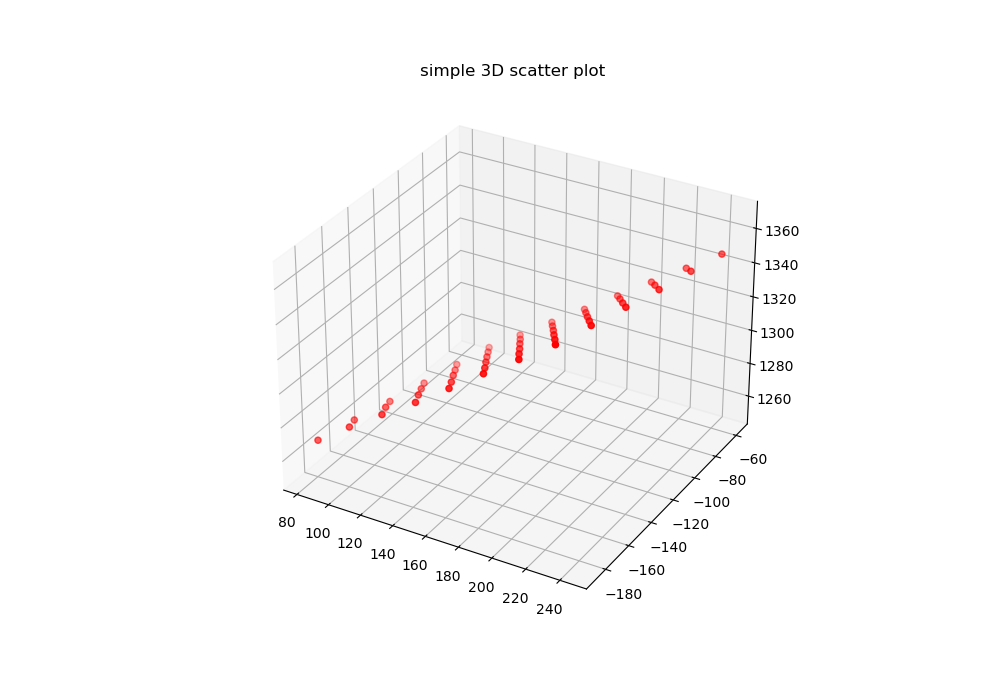

In [9]:
# Import libraries
%matplotlib widget
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


# Points
x = p3ds[:,0]
y = p3ds[:,1]
z = p3ds[:,2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(x, y, z, color = "red")
plt.title("simple 3D scatter plot")

# show plot
plt.show()


In [10]:
np.linalg.norm(p3ds[0]-p3ds[1])

25.106289937629302

In [12]:
import numpy as np
import cv2

def get_centerpoints(img):
    # Define Trackbar On Change Value
    def do_nothing(x):
        pass

    # Init Empty Black Image To Describe Lower limit and Upper limit for Color Detection
    L_img = np.zeros((480, 640, 3), np.uint8)
    U_img = np.zeros((480, 640, 3), np.uint8)

    # Init Windows
    cv2.namedWindow("Res",cv2.WINDOW_NORMAL)
    cv2.namedWindow("HSV Control",cv2.WINDOW_NORMAL)

    # Init Trackbar for Setting Lower Limit and Upper Limit Of HSV Detection
    cv2.createTrackbar("Lower Hue","HSV Control"        ,28,179,do_nothing)
    cv2.createTrackbar("Lower Saturation","HSV Control" ,245,255,do_nothing)
    cv2.createTrackbar("Lower Value","HSV Control"      ,150,255,do_nothing)
    cv2.createTrackbar("Upper Hue","HSV Control"        ,34,179,do_nothing)
    cv2.createTrackbar("Upper Saturation","HSV Control" ,255,255,do_nothing)
    cv2.createTrackbar("Upper Value","HSV Control"      ,255,255,do_nothing)

    # Define Windows Initial Position
    cv2.moveWindow("Res",50,100)
    cv2.moveWindow("HSV Control",475,100)

    # Read Stream
    while(1):
        
        imageFrame = cv2.imread(img)   
    
        
        # Assign Trackbar value to variable
        L_H = cv2.getTrackbarPos("Lower Hue","HSV Control")
        L_S = cv2.getTrackbarPos("Lower Saturation","HSV Control")
        L_V = cv2.getTrackbarPos("Lower Value","HSV Control")    
        
        U_H = cv2.getTrackbarPos("Upper Hue","HSV Control")
        U_S = cv2.getTrackbarPos("Upper Saturation","HSV Control")
        U_V = cv2.getTrackbarPos("Upper Value","HSV Control")
        
        # Assert Boundaries
        if L_H > U_H:
            L_H = U_H
        if L_S > U_S:
            L_S = U_S
        if L_V > U_V:
            L_V = U_V
            
            
        L_limit=np.array([L_H,L_S,L_V]) # setting the lower limit
        U_limit=np.array([U_H,U_S,U_V]) # setting the upper limit
            
        # Convert Image To HSV
        into_hsv =cv2.cvtColor(imageFrame,cv2.COLOR_BGR2HSV)
        
        # Blur to reduce Noise
        into_hsv = cv2.blur(into_hsv,(7,7))
        
        # Create Mask
        b_mask=cv2.inRange(into_hsv,L_limit,U_limit)
        
        
        # Reduce Mask Splitting on same region
        kernel = np.ones((5, 5), np.uint8)
        b_mask = cv2.dilate(b_mask, kernel, iterations=3)

        # creating the mask using inRange() function
        # this will produce an image where the color of the objects
        # falling in the range will turn white and rest will be black
        #imageFrame=cv2.bitwise_and(imageFrame,imageFrame,mask=fgmask)
        
        blue=cv2.bitwise_and(imageFrame,imageFrame,mask=b_mask)
        
        
        L_img[:] = [L_H,L_S,L_V]
        U_img[:] = [U_H,U_S,U_V]
        L_img = cv2.cvtColor(L_img,cv2.COLOR_HSV2BGR)
        U_img = cv2.cvtColor(U_img,cv2.COLOR_HSV2BGR)
        outputControl = np.concatenate((L_img,U_img),axis=1)
        
        contours, hierarchy = cv2.findContours(b_mask,
                                            cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)
        centerpoints = []
        for pic, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            if(area > 300):
                x, y, w, h = cv2.boundingRect(contour)
                imageFrame = cv2.rectangle(imageFrame, (x, y),
                                        (x + w, y + h),
                                        (255, 0, 0), 2)
                centerpoint = (x + w//2, y + h//2)
                centerpoints.append(centerpoint)
                cv2.circle(imageFrame, centerpoint, 
                        radius=3, color=(255,255,0), thickness=-1)
                cv2.putText(imageFrame, "Detected Object", (x, y),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (255, 0, 0))
        outputFrame = np.concatenate((imageFrame,blue),axis=1)
        
        
        cv2.imshow("Res", outputFrame)
        cv2.imshow("HSV Control",outputControl)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
    return centerpoints


In [13]:
cc_1 = get_centerpoints('./data/triangulate/1/IMG_20230428_150246.jpg')
cc_2 = get_centerpoints('./data/triangulate/2/IMG_20230428_150245.jpg')
cc_1,cc_2

([(1535, 570), (1465, 558), (1464, 557), (1343, 538), (1200, 519)],
 [(658, 573), (722, 571), (946, 561), (818, 563)])

In [6]:
imageFrame = cv2.imread('./data/triangulate/1/IMG_20230428_150246.jpg')  
for c in cc_1:
    cv2.circle(imageFrame, c, 
        radius=3, color=(255,255,0), thickness=-1)
cv2.imshow('img', imageFrame)
cv2.waitKey(0)
cv2.destroyAllWindows()

imageFrame = cv2.imread('./data/triangulate/2/IMG_20230428_150245.jpg')  
for c in cc_2:
    cv2.circle(imageFrame, c, 
        radius=3, color=(255,255,0), thickness=-1)
cv2.imshow('img', imageFrame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
def triangulate(mtx1, mtx2, R, T, uvs1, uvs2):
 
    uvs1 = np.array(uvs1)
    uvs2 = np.array(uvs2)
 
 
    
    #RT matrix for C1 is identity.
    RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
    P1 = mtx1 @ RT1 #projection matrix for C1
 
    #RT matrix for C2 is the R and T obtained from stereo calibration.
    RT2 = np.concatenate([R, T], axis = -1)
    P2 = mtx2 @ RT2 #projection matrix for C2
 
    def DLT(P1, P2, point1, point2):
 
        A = [point1[1]*P1[2,:] - P1[1,:],
             P1[0,:] - point1[0]*P1[2,:],
             point2[1]*P2[2,:] - P2[1,:],
             P2[0,:] - point2[0]*P2[2,:]
            ]
        A = np.array(A).reshape((4,4))

 
        B = A.transpose() @ A
        from scipy import linalg
        U, s, Vh = linalg.svd(B, full_matrices = False)
 
        print('Triangulated point: ')
        print(Vh[3,0:3]/Vh[3,3])
        return Vh[3,0:3]/Vh[3,3]
 
    p3ds = []
    for uv1, uv2 in zip(uvs1, uvs2):
        _p3d = DLT(P1, P2, uv1, uv2)
        p3ds.append(_p3d)
    p3ds = np.array(p3ds)
 
    return p3ds


In [15]:
PC = triangulate(mtx1,mtx2,R,T,cc_1,cc_2)
PC

Triangulated point: 
[365.43793887  24.00226698 923.33947535]
Triangulated point: 
[338.10062007  17.36869928 974.12885122]
Triangulated point: 
[ 395.29624214    7.33376304 1139.70602545]
Triangulated point: 
[ 277.97426509    3.10976788 1059.986938  ]


array([[ 365.43793887,   24.00226698,  923.33947535],
       [ 338.10062007,   17.36869928,  974.12885122],
       [ 395.29624214,    7.33376304, 1139.70602545],
       [ 277.97426509,    3.10976788, 1059.986938  ]])